In [1]:
import numpy as np
from CPS import NearestNeighboursPredictionMachine
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from martingale import PluginMartingale

In [2]:
N = 2500
P = 20
d = 3
np.random.seed(2024)
X = np.random.uniform(0, 1, (N, P))
Y = np.sin(X.sum(axis=1)**d) + np.random.normal(0, 0.1, N) # Gaussian noise wiht zero mean and variance 0.1

In [4]:
cps = NearestNeighboursPredictionMachine(31)
martingale = PluginMartingale()
rnd_generator = np.random.default_rng(2024)

initial_training_size = 500
X_train = X[:initial_training_size]
y_train = Y[:initial_training_size]

X_run = X[initial_training_size:]
y_run = Y[initial_training_size:]

cps.learn_initial_training_set(X_train, y_train)

p_values = []

Err = 0
predictions = np.zeros((X_run.shape[0], 7))
for i, (obj, label) in tqdm(enumerate(zip(X_run, y_run)), total=y_run.shape[0]):
    # Reality presents the object x
    x = obj
    # Forecaster outputs cpd
    cpd, precomputed = cps.predict_cpd(x, return_update=True, save_time=True)
    # Forecaster outputs Gamma
    tau = rnd_generator.uniform(0, 1)
    Gamma = cpd.predict_set(tau, epsilon=0.1)
    width = cpd.width(Gamma)
    # Reality presents the label
    cps.learn_one(x, label, precomputed)  
    # Check if we made an error
    err = cpd.err(Gamma, label)
    Err += err
    # Compute smoothed p-value
    tau = rnd_generator.uniform(0, 1)
    p = cpd(label, tau)
    p_values.append(p)
    # Update martingale
    martingale.update_log_martingale(p)

    # Save the result from the iteration
    predictions[i, 0] = Gamma[0] # Lower 
    predictions[i, 1] = Gamma[1] # Upper 
    predictions[i, 2] = err # Error
    predictions[i, 3] = label # True label
    predictions[i, 4] = width # True label
    predictions[i, 5] = p # Smoothed p-value
    predictions[i, 6] = martingale.M # Martingale value

predictions[:,2].mean()
tau = np.random.uniform(0, 1)
y_space = np.linspace(-2, 2, num=1000)
plt.plot(y_space, [cpd(y, tau) for y in y_space], label='Randomised')
plt.legend()
predictions[:,2].mean()

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
# Sorting the distance matrix is the time consuming bit. It really should be possible to save and reuse computations here...
# Think about it!
cpd.time_dict

{'Compute distance matrix': 0.016763925552368164,
 'Sort distance matrix': 0.6764085292816162,
 'Find all neighbours and semi-neighbours': 0.03395962715148926,
 'Loop': 0.00040435791015625}

0.104


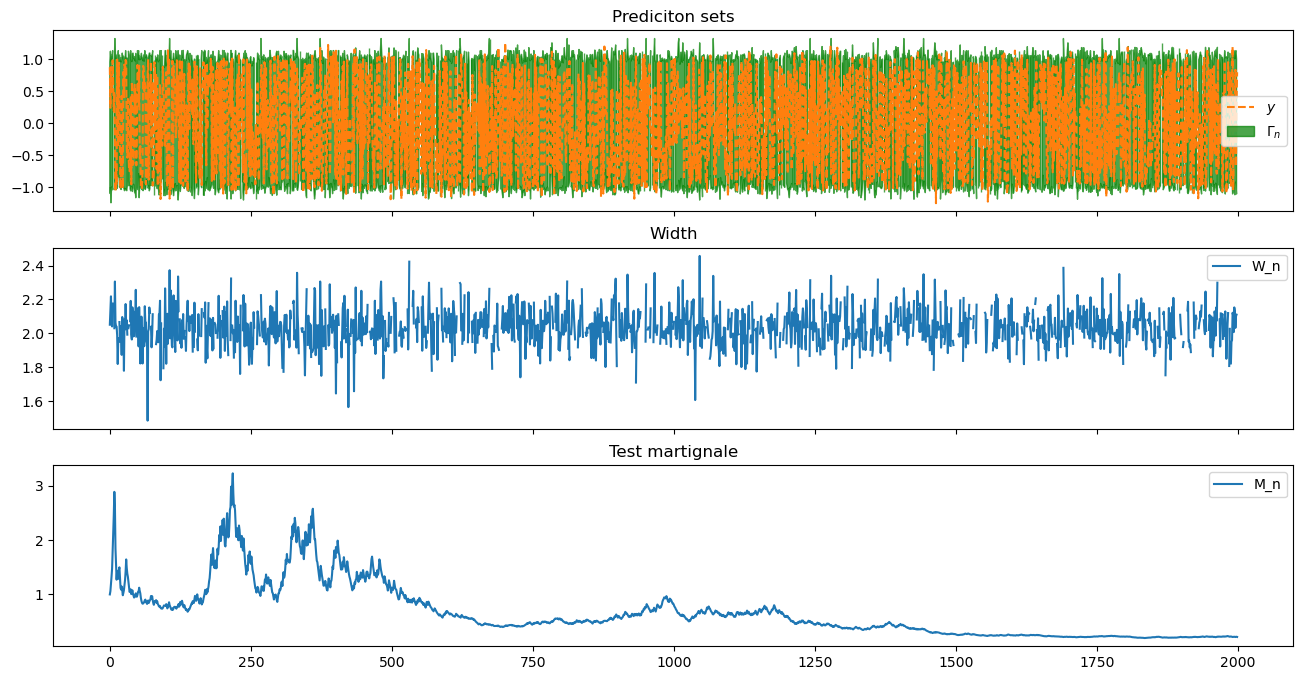

In [ ]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(16, 8))
axs[0].plot(y_run, label=r'$y$', color='C1', linestyle='--')
axs[0].fill_between(
    x=[i for i, _ in enumerate(y_run)],
    y1=predictions[:,0],
    y2=predictions[:,1],
    label=r'$\Gamma_n$',
    color='green',
    alpha=0.7,
)
axs[0].legend()
axs[0].set_title('Prediciton sets')

axs[1].plot(predictions[:,4], label=r'W_n')
axs[1].legend()
axs[1].set_title('Width')

axs[2].plot(predictions[:,6], label=r'M_n')
axs[2].legend()
axs[2].set_title('Test martignale')